In [1]:
#  NumPy and Pandas imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import autocorrelation_plot

#  Reading time series
from pandas_datareader import data

import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Stationarity
import statsmodels.api as sm
import statsmodels.tsa as tsa

#  Time stamps
import datetime as datetime

#  Visualization (sns is a visualization library based on matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline


In [2]:
#  Start and End Date
start = datetime.date(2016, 4, 10)
end = datetime.date(2019, 4, 10)

#  Assign a database with historical stock quotes from Yahoo! Finance to CSCO
#  Cisco Systems, Inc.
CSCO = data.get_data_yahoo('CSCO', start, end)
CSCO_closing_prices = pd.DataFrame()
CSCO_closing_prices['Adj Close'] = CSCO['Adj Close']
CSCO_closing_prices['Date'] = CSCO_closing_prices.index
CSCO_closing_prices.set_index('Date')
#CSCO_closing_prices['Date'] = CSCO_closing_prices.index
CSCO_percent_change = CSCO_closing_prices['Adj Close'].pct_change()

# Stationarity
---------
Disaggregate a time series into three components -- trend, seasonal, residual

* trend component
    - supposed to capture the slowly-moving overall level of the series
* seasonal component
    - captures patterns that repeat every season
* Residual component
    - residual is what is left

Multiplicative model is better because of lack of consistent
seasonal trends

Stationarity Analysis: Differencing, Decomposition


First note that the data is clearly non-stationarity. This is 
A problem for time series analysis because non-stationarity data
is hard to reason about. 


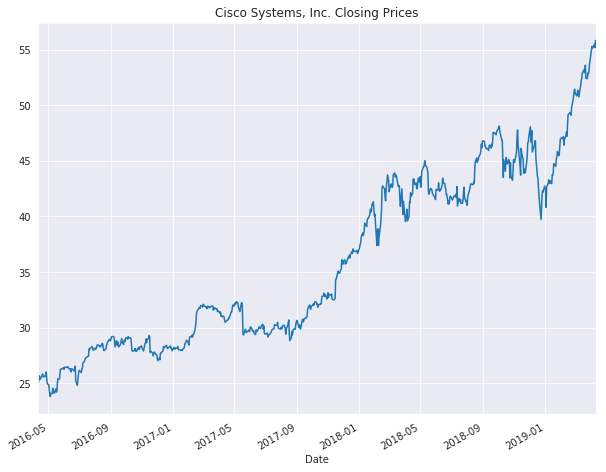

In [3]:
CSCO_closing_prices['Adj Close'].plot(title=
                                      "Cisco Systems, Inc. Closing Prices",
                                      figsize=(10, 8))

## Differencing
The basic idea is taking differences between successive occurrences of a time series
Δx<sub>t</sub> = x<sub>t</sub> - x<sub>t-1</sub> so that Δx<sub>t</sub> has a 
constant mean and variance (it can then be treated as stationary series)
##### First-Order differencing

In [4]:
CSCO_closing_prices['First Order'] = CSCO['Adj Close'] - CSCO['Adj Close'].shift()
CSCO_closing_prices.head()

,Adj Close,Date,First Order
Date,,,
2016-04-11,25.081974,2016-04-11,NaN
2016-04-12,25.100136,2016-04-12,0.018162
2016-04-13,25.635920,2016-04-13,0.535784
2016-04-14,25.654081,2016-04-14,0.018162
2016-04-15,25.336243,2016-04-15,-0.317839


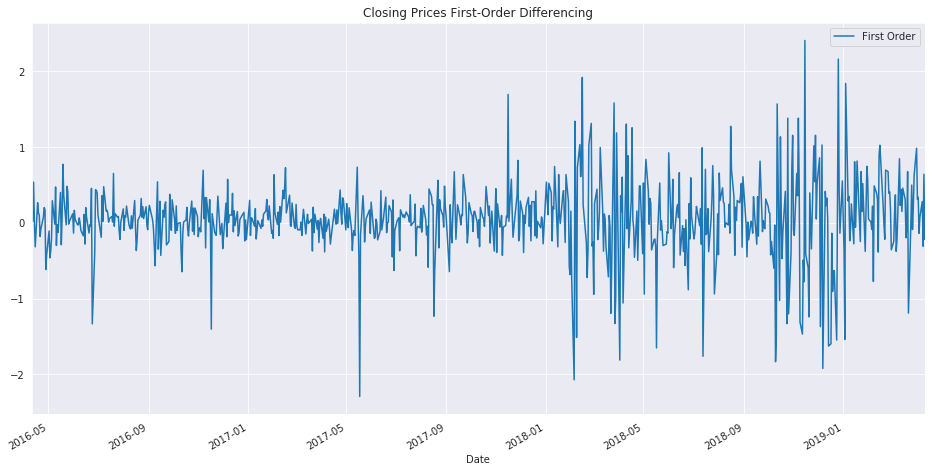

In [5]:
CSCO_closing_prices['First Order'].plot(legend=True,
                                        title="Closing Prices First-Order Differencing",
                                        figsize=(16, 8))

Data is no longer trending up, is now centered around zero. The variance is
a problem though. It increases over time, which is a sign the data is 
non-stationary and also exponentially increasing

Apply a transformation which penalizes higher values more than smaller values.
Using log transformations

Important property of Log-returns is that they're symmetrical around 0 with
respect to addition

This property makes it possible to talk about an average return
(if a stock goes down 20% over a period of time, it has to gain 25% to be back
where you started. For the log-return the numbers are .223 down over a period
of time and .233 up to get back to where you started)

Arithmetic returns allow easier cross-sectional aggregation, log returns allow
for easier time aggregation (grouping rows)

DataFrame .apply(func) method, "func" is the function to apply to each column
or row. 

lambda function: 
small anonymous function
Syntax ---- lambda *arguments* : *expression*

The lambda function takes 'Adj Close' values and applies a log transformation
to them. (log function is from NumPy package, NOT ON A NUMPY ARRAY)


This gives us the original closing price with a log transformation applied
to "flatten" the data from an exponential curve to a linear curve.


In [8]:
CSCO_closing_prices['Log Transform'] = CSCO['Adj Close'].apply(lambda x: np.log(x))
CSCO_closing_prices[['Log Transform', 'Adj Close']].head()

,Log Transform,Adj Close
Date,,
2016-04-11,3.222149,25.081974
2016-04-12,3.222873,25.100136
2016-04-13,3.243994,25.635920
2016-04-14,3.244703,25.654081
2016-04-15,3.232236,25.336243


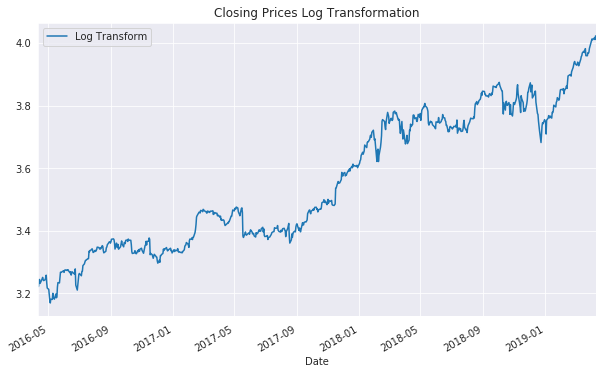

In [9]:
CSCO_closing_prices['Log Transform'].plot(legend=True,
                                        title="Closing Prices Log Transformation",
                                        figsize=(10, 6))

Check the effect with pandas **.rolling_var()** function, variance measures
the distance from the mean. 

We can see in the bottom graph that the log transformation has made the 
variance more constant

In [36]:
#  calculate rolling variance of original closing prices

CSCO_closing_prices['Variance'] = CSCO['Adj Close'].rolling(window=30, 
                                               min_periods=None, 
                                               center=True).var()

#   calculate rolling variance of log transformed closing prices
CSCO_closing_prices['Log Variance'] = \
    CSCO_closing_prices['Log Transform'].rolling(30, center=True).var()

In [10]:
#  Display DataFrame
CSCO_closing_prices.dropna().head()

,Adj Close,Date,First Order,Log Transform,Variance,Log Variance
Date,,,,,,
2016-05-02,24.854948,2016-05-02,-0.108973,3.213057,0.475166,0.000766
2016-05-03,24.391808,2016-05-03,-0.463140,3.194247,0.480474,0.000775
2016-05-04,24.010405,2016-05-04,-0.381403,3.178487,0.506318,0.000816
2016-05-05,23.801542,2016-05-05,-0.208862,3.169750,0.547216,0.000878
2016-05-06,24.092133,2016-05-06,0.290590,3.181885,0.584916,0.000936


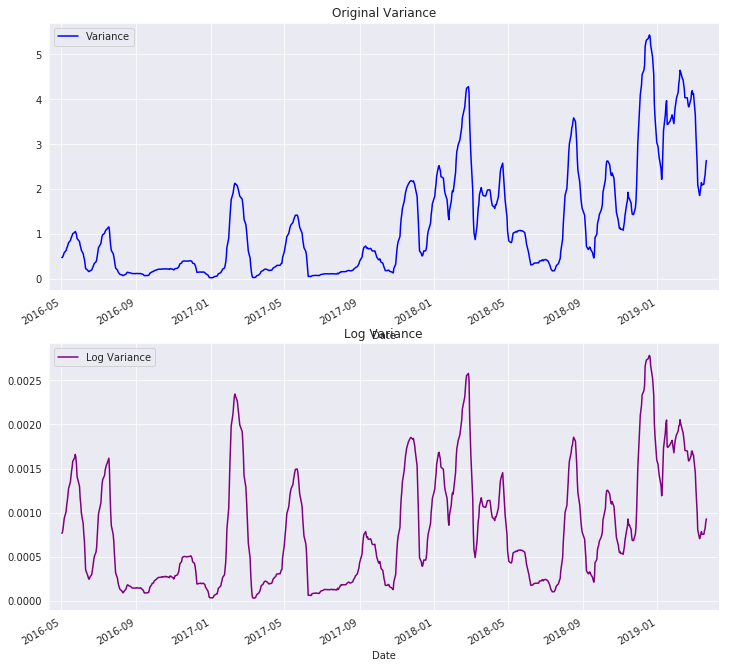

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
#  Plot the rolling variance for original closing prices
CSCO_closing_prices['Variance'].plot(ax=ax[0],
                                     legend=True,
                                     title='Original Variance',
                                     color='blue')
#  Plot the rolling variance for log transformed closing prices
CSCO_closing_prices['Log Variance'].plot(ax=ax[1],
                                         legend=True,
                                         title='Log Variance',
                                         color='purple')

Calculate the logged first order difference

In [12]:
#  Get first order difference
CSCO_closing_prices['Logged First Order'] = CSCO_closing_prices['Log Transform'].diff()
#  Display data
CSCO_closing_prices.dropna().head()

,Adj Close,Date,First Order,Log Transform,Variance,Log Variance,Logged First Order
Date,,,,,,,
2016-05-02,24.854948,2016-05-02,-0.108973,3.213057,0.475166,0.000766,-0.004375
2016-05-03,24.391808,2016-05-03,-0.463140,3.194247,0.480474,0.000775,-0.018810
2016-05-04,24.010405,2016-05-04,-0.381403,3.178487,0.506318,0.000816,-0.015760
2016-05-05,23.801542,2016-05-05,-0.208862,3.169750,0.547216,0.000878,-0.008737
2016-05-06,24.092133,2016-05-06,0.290590,3.181885,0.584916,0.000936,0.012135


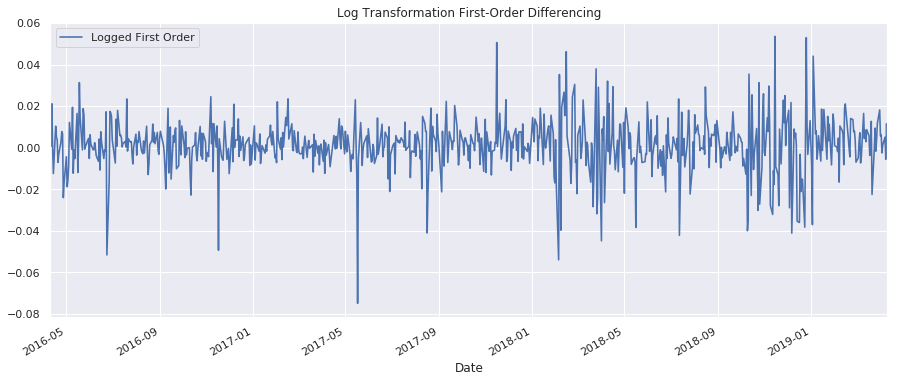

In [155]:
CSCO_closing_prices['Logged First Order'].plot(legend=True,
                                        title="Log Transformation First-Order Differencing",
                                        figsize=(15, 6))

First-order differences should be independent and identically distributed with a constant
mean and variance, which means no autocorrelation.

Check this with lag variables x<sub>t-1</sub>, x<sub>t-2</sub>, etc.. and compare
them to x<sub>t</sub>

Check the bivariate relationship for a mass around zero and the univariate distributions
as evenly distributed.

In [14]:
#  Create lag attributes for 5 days and 20 days
CSCO_closing_prices['Log Difference Lag 5'] = CSCO_closing_prices['Logged First Order'].shift(5)
CSCO_closing_prices['Log Difference Lag 20'] = CSCO_closing_prices['Logged First Order'].shift(20)

/home/trevor/anaconda3/envs/CS4315/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


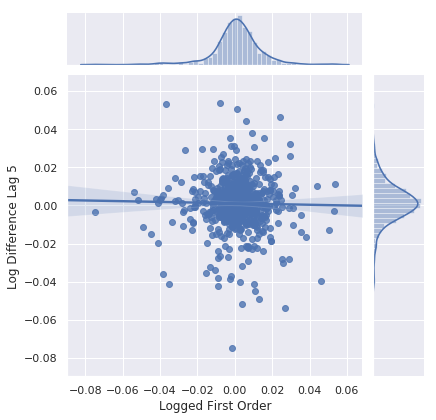

In [156]:
#  Check distribution in scatter plot of original attribute vs lagged attribute
sns.jointplot('Logged First Order', 'Log Difference Lag 5', CSCO_closing_prices, kind='reg', size=6)

/home/trevor/anaconda3/envs/CS4315/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


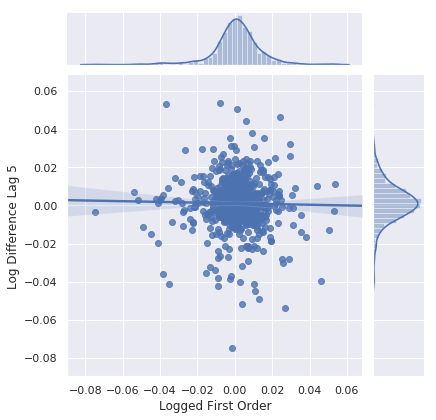

In [157]:
sns.jointplot('Logged First Order', 'Log Difference Lag 5', CSCO_closing_prices, kind='reg', size=6)


Verify if first-order differencing standardized the time series with an
**autocorrelation function (ACF)** The ACF computes the correlation between a variable
and itself at each lag step up to the set limit 40.

In [197]:
log_acf = sm.tsa.acf(CSCO_closing_prices['Logged First Order'].dropna())

Plotting the ACF shows the correlation between a value at time t
and any time prior to t (up to 40 days behind). This time series model
is known as a **Random Walk**

A random walk is different than a list of rand numbers since the next value
in the sequence is a modification of the previous value in the sequence.
Generating the series forces a dependence from one time point to the next. This
dependence provides consistency that large jumps in an independent series doesnt.
The dependency gives the time series the name "random walk"

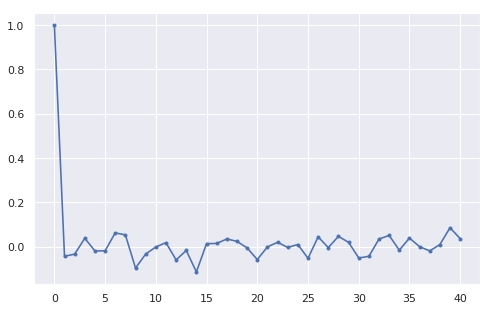

In [196]:
#  Plot the Autocorrelation Function with Statsmodels package
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(log_acf, marker='.')

Plotting with pandas **autocorrelation_plot()** also visualizes the randomness
of a function. The horizontal dashed lines correspond to the 99% confidence band.
If a time series is random, then none of the autocorrelations will be significantly 
non-zero. As we can see here, the log transformation standardizes the dataset.

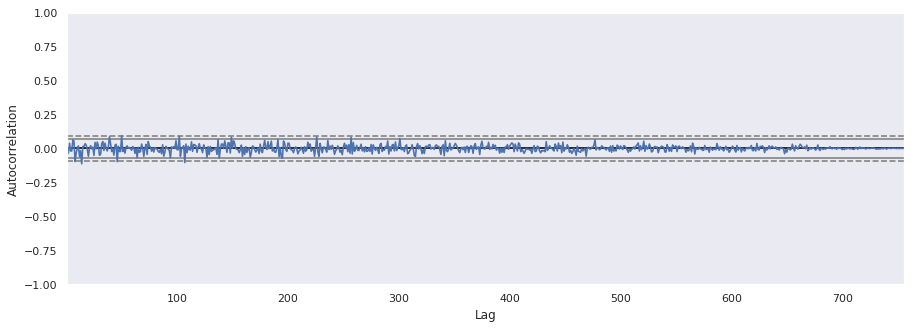

In [163]:
#  Plot Autocorrelation Function with pandas "autocorrelation_plot()" function
plt.figure(figsize=(15, 5))
autocorrelation_plot(CSCO_closing_prices['Logged First Order'].dropna())

The stats model package seasonal_decompose() function is used to decompose the time
series into trend, seasonality, and residual components.

This shows us that trend is going up and seasonality is following a regular pattern.

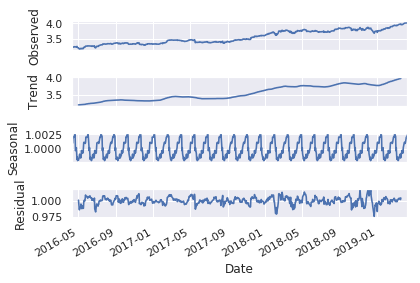

In [195]:
decompose_data = sm.tsa.seasonal_decompose(CSCO_closing_prices['Log Transform'], 
                                           model="multiplicative", 
                                           freq=30)
figures = decompose_data.plot()
plt.rcParams['figure.figsize'] = [10.0, 12.0]

# Smoothing
--------
1. Moving Averages, 2. Exponential smoothing
The models are referred to as smoothing models because it smoothens out bumps in the dataset. 
### Moving Averages
**Moving averages** (**MA**) at time index *t* estimate the average trend cycle of component F<sub>t</sub>,
it is calculated by taking the average over the time period of t ± *k* where *k* is the range of the MA.

Taking moving averages has an effect of smoothing the original time series by eliminating random noise.

Note the larger the window the more data missing at the beginning of the curve. A window size
*n* requires *n* data points before the measure is calculated.

The larger the window, the longer it takes the time series to react to a change in the price
  


In [194]:
CSCO_closing_prices['MA for 10 days'] = CSCO_closing_prices['Adj Close'].rolling(10).mean()
CSCO_closing_prices['MA for 20 days'] = CSCO_closing_prices['Adj Close'].rolling(20).mean()
CSCO_closing_prices['MA for 50 days'] = CSCO_closing_prices['Adj Close'].rolling(50).mean()


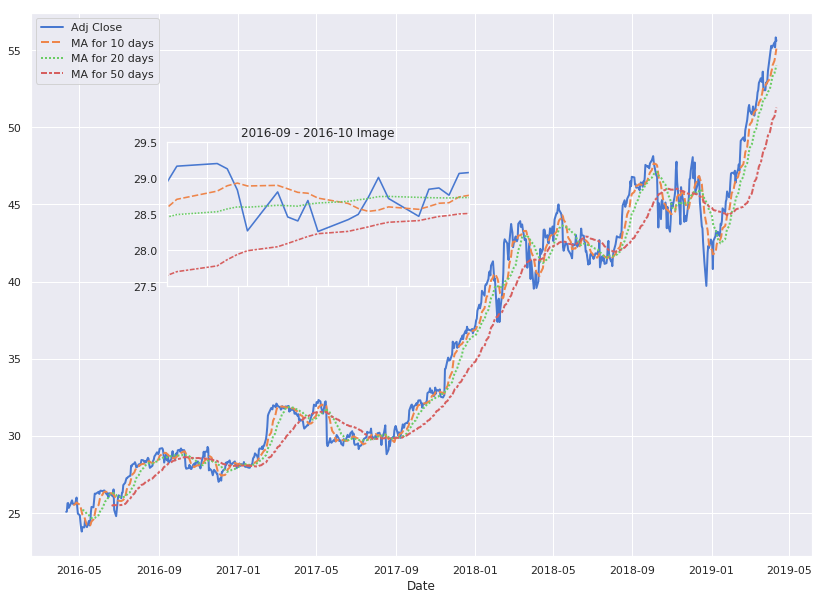

In [193]:
#CSCO_closing_prices[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(subplots=False,
 #                                                                                legend=True,
  #                                                                               figsize=(10, 6))
sns.set(rc={"lines.linewidth": 2.0})
figsize_1 = (14, 10)
figure_1, ax_1 = plt.subplots(figsize=figsize_1)
palette = sns.color_palette('muted', n_colors=4)
sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']],
             legend='full',
             palette=palette,
             hue=['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
             ax=ax_1)

ax2 = plt.axes([0.26, 0.5, .3, .2])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-09 - 2016-10 Image')
ax2.set_xlim(left='2016-09', right='2016-10')
ax2.set_ybound(27.5, 29.5)

##### Expanding mean
An expanding window mean is a variant of the moving window mean. The pandas **.expanding()** function 
repeatedly calculates the mean by always starting with the first value in the time series and
for every iteration, increases the window size by one. 

In general, a fixed rolling window (Moving Average) time series is better than the expanding window time series. 

In [192]:
CSCO_closing_prices['Expanding Mean'] = CSCO_closing_prices['Adj Close'].expanding(center=True).mean()
test = CSCO_closing_prices[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 20 days']]


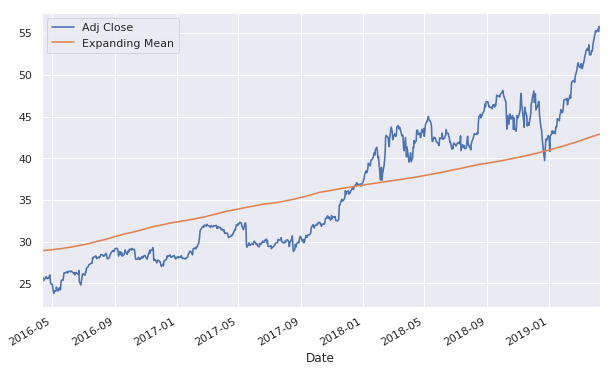

In [191]:
CSCO_closing_prices[['Adj Close', 'Expanding Mean']].plot(subplots=False,
                                                          legend=True,
                                                          figsize=(10, 6))

## Exponential Smoothing
The smoothing methods are based on an assumption that time series data is locally stationary
with small variations in the mean. Therefore, we can use the mean at time *t* to predict 
*t+1*, where the time delta is small enough to keep the signal stationary. 

The major limitation of moving average-based models is that they treat all *n* samples 
used in smoothing equally and ignore the observation recency effect, which is giving higher
weights to recent observations. 

This is solved with exponential smoothing. The speed at which older responses are dampened
(smoothed) is a function of the alpha **α** value.

The higher alpha α, the closer the exponential smoothing line is to the original line. This means
larger values of α reduce the evel of smoothing.    

In [190]:
CSCO_closing_prices['ES α = .1'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.1).mean()
CSCO_closing_prices['ES α = .3'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.3).mean()
CSCO_closing_prices['ES α = .5'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.5).mean()
CSCO_closing_prices['ES α = .7'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.7).mean()
CSCO_closing_prices['ES α = .9'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.9).mean()
CSCO_closing_prices['ES α = .2'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.2).mean()
CSCO_closing_prices['ES α = .15'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.15).mean()
CSCO_closing_prices['ES α = .25'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.25).mean()
CSCO_closing_prices['ES α = .18'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.18).mean()


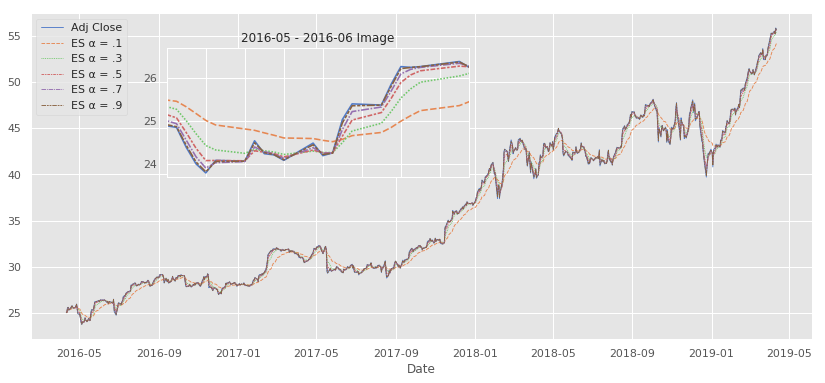

In [189]:
#  Specify matplotlob Figure and Axes
sns.set(rc={"lines.linewidth": 0.9})
plt.style.use('ggplot')
figsize_2 = (14, 6)
figure_2, ax_2 = plt.subplots(figsize=figsize_2)
palette = sns.color_palette('muted', n_colors=6, desat=.9)
ax.set_title('Visualize Exponential Smoothing Alphas (α)')

sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9']],
             legend='full',
             palette=palette,
             hue=['Adj Close', 'ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9'],
             ax=ax_2,
             err_style='bars'
             )

ax2 = plt.axes([0.26, 0.5, .3, .3])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9']],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-05 - 2016-06 Image')
ax2.set_xlim(left='2016-05', right='2016-06')
ax2.set_ybound(23.7, 26.7)

##### Narrowing Exponential Smoothing Factor with Mean Squared Error and Mean Absolute Error
It looks like the best exponential smoothing model is around ES α = .12 - .14. The alpha value is low
because the more observations in the dataset, the lower the optimal alpha value is. ES α = .1 is 
probably too low and will smooth the data too much.  

In [188]:
MSE = ['ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9', 'ES α = .2', 'ES α = .15',
       'ES α = .25', 'ES α = .18']
MSE[0] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .1'])
MSE[1] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .3'])
MSE[2] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .5'])
MSE[3] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .7'])
MSE[4] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .9'])
MSE

[0.9983925290804362,
 0.22582592179398833,
 0.07878252789418477,
 0.02373626554073894,
 0.0024709550046704324,
 0.41707513418197456,
 0.6092544403301028,
 0.3020508905037807,
 0.481074127748981]

In [187]:
MAE = ['ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9', 'ES α = .2', 'ES α = .15',
       'ES α = .25', 'ES α = .18']
MAE[0] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .1'])
MAE[1] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .3'])
MAE[2] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .5'])
MAE[3] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .7'])
MAE[4] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .9'])
MAE

[0.7624457943640459,
 0.33402414302536815,
 0.19133895477083382,
 0.10370407181940026,
 0.033007923726448445,
 0.4679660694254713,
 0.5798321973383816,
 0.3914103987007345,
 0.507003835291016]

### Exponential Smoothing: Finding optimal Smoothing Factor (α)
A smoothing factor closer to 1.0 have less of smoothing effect and give greater weight to 
recent changes in the data (when α = 1, it becomes the observation). 
While values closer to 0.0 have a greater smoothing effect 
and are less responsive to recent changes. α is the "memory" of the estimator.

The smoothing factors tested for optimization are α = .120, .125, .130, .135, .140 
(Narrowed down from previous part)

In [ ]:
CSCO_closing_prices['ES α = .120'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.120).mean()
CSCO_closing_prices['ES α = .125'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.125).mean()
CSCO_closing_prices['ES α = .130'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.130).mean()
CSCO_closing_prices['ES α = .135'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.135).mean()
CSCO_closing_prices['ES α = .140'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.140).mean()
CSCO_closing_prices['ES α = .145'] = CSCO_closing_prices['Adj Close'].ewm(alpha=0.145).mean()
CSCO_closing_prices['ES α = .80'] = CSCO_closing_prices['Adj Close'].ewm(alpha=.80).mean()


Graphically visualize the smoothing factors

In [ ]:
#  Specify matplotlob Figure and Axes
sns.set(rc={"lines.linewidth": 0.9})
plt.style.use('ggplot')
figsize_1 = (14, 6)
figure_1, ax_1 = plt.subplots(figsize=figsize_1)
palette = sns.color_palette('muted', n_colors=6, desat=.9)
ax_1.set_title('Visualize Exponential Smoothing Alphas (α)')

sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'ES α = .120', 'ES α = .125', 'ES α = .130', 
                                       'ES α = .135', 'ES α = .140',]],
             legend='full',
             palette=palette,
             hue=['Adj Close', 'ES α = .120', 'ES α = .125', 'ES α = .130', 'ES α = .135', 'ES α = .140',],
             ax=ax_1,
             err_style='bars'
             )

ax2 = plt.axes([0.26, 0.5, .3, .3])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'ES α = .120', 'ES α = .125', 'ES α = .130', 
                                       'ES α = .135', 'ES α = .140',]],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-05 - 2016-06 Image')
ax2.set_xlim(left='2016-05', right='2016-06')
ax2.set_ybound(23.7, 26.7)


##### Checking Exponential Smoothing Model Accuracy with Mean Squared Error and Mean Absolute Error
We will use α = .130 for the predictive dataset.  

In [ ]:
MSE_2 = ['ES α = 0', 'ES α = .99', 'ES α = .130', 'ES α = .135', 'ES α = .140', 'ES α = .145']
MSE_2[0] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = 0'])
MSE_2[1] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .99'])
MSE_2[2] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .130'])
MSE_2[3] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .135'])
MSE_2[4] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .140'])
MSE_2[5] = mean_squared_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .145'])
MSE_2

In [ ]:
MAE_2 = ['ES α = .120', 'ES α = .125', 'ES α = .130', 'ES α = .135', 'ES α = .140', 'ES α = .145']
MAE_2[0] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .120'])
MAE_2[1] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .125'])
MAE_2[2] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .130'])
MAE_2[3] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .135'])
MAE_2[4] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .140'])
MAE_2[5] = mean_absolute_error(CSCO_closing_prices['Adj Close'], CSCO_closing_prices['ES α = .145'])
MAE_2 


##### Exponential Weighted Moving Average (EWMA)
EWMA has less lag, which makes it more sensitive to recent prices and price changes. The more 
recent values favored means it will turn before regular MA. It's decision is partly based on
momentum. A simple MA will represent a truer average of prices for the entire time period.
We can see that EWMA, and MA still don't represent the price as well as a 
regular exponential smoothing model with α = .1

In [186]:
CSCO_closing_prices['EWMA for 10 days'] = CSCO_closing_prices['Adj Close'].ewm(span=10).mean()


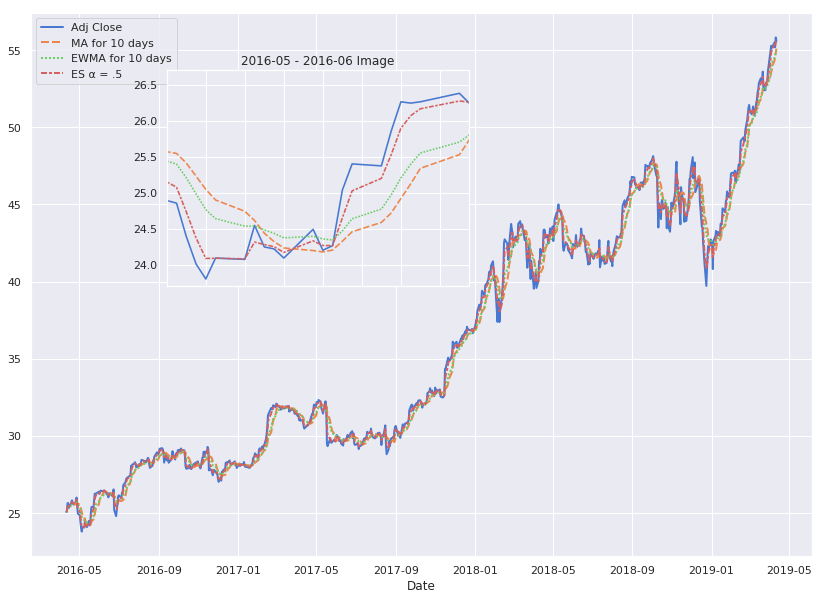

In [185]:
sns.set(rc={"lines.linewidth": 2.0})
figsize_3 = (14, 10)
figure_3, ax_3 = plt.subplots(figsize=figsize_3)
palette = sns.color_palette('muted', n_colors=4)
sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'MA for 10 days', 'EWMA for 10 days', 'ES α = .5']],
             legend='full',
             palette=palette,
             hue=['Adj Close', 'MA for 10 days', 'EWMA for 10 days'],
             ax=ax_3)

ax2 = plt.axes([0.26, 0.5, .3, .3])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Adj Close', 'MA for 10 days', 'EWMA for 10 days', 'ES α = .5']],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-05 - 2016-06 Image')
ax2.set_xlim(left='2016-05', right='2016-06')
ax2.set_ybound(23.7, 26.7)

             